# **Practice**. Учим нейронку распознавать героев "Наруто"


---

Если вы хотите параллельно запускать обучение, то стоит сразу подготовиться, скачать данные и положить себе на гугл-диск.
Данные берем [тут](https://drive.google.com/file/d/1dcY6ynHCIPLowqkduabiHiGSjOnYbLU8/view?usp=sharing).

## **План**
1. Готовим данные для экспериментов
2. Как написать нейронную сеть
3. Как обучить нейронную сеть
4. Проводим эксперимент

## **1. Готовим данные для экспериментов**

Мы хотим обучить сеть классифицировать лица героев, значит у нас должны быть **обучающие данные** - для задачи классификации изображений это, очевидно, картинки и классы этих картинок, а также **тестовые данные** - выборка такого же формата (картинка + её класс) на которых мы не будем учиться, но сможем проверить насколько хорош наш алгоритм.

In [ ]:
import os
import cv2
import PIL
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

torch.cuda.is_available()

In [ ]:
# Зафиксируем сиды, чтобы воспроизводимости добавить
seed = 24
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.mps.manual_seed(seed)

In [ ]:
# Эта ячейка нужна, если вы работаете в colab
# Прикручиваем свой гуглдиск, куда закинули архивы с данными
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

In [ ]:
# Эта ячейка нужна, если вы работаете в colab
# Команды для bash пишутся с !
!ls '/content/gdrive/My Drive/Webinar/'

In [ ]:
# Эта ячейка нужна, если вы работаете в colab
# разархивируем, -q - не выводить логи
!unzip -q '/content/gdrive/My Drive/Webinar/naruto-dataset.zip' -d './'

In [ ]:
root = './naruto-dataset/'
train_ann_path = os.path.join(root, 'train.csv')
test_ann_path = os.path.join(root, 'test.csv')

# Читаем аннотацию
train_df = pd.read_csv(train_ann_path)
test_df = pd.read_csv(test_ann_path)

In [ ]:
train_df

In [ ]:
class_map = {0: 'Chie', 1: 'Ebizo', 2: 'Gaara', 3: 'Iruka', 4:'Kankuro', 5:'Naruto', 6: 'Sakura',
             7:'Sasuke', 8: 'Shikamaru', 9: 'Shizune', 10: 'Temari', 11: 'Teuchi', 12: 'Tsunade'}

In [ ]:
# Посмотрим на распределение по классам
labels, counts_train = np.unique(train_df['label'], return_counts=True)
_, counts_test = np.unique(test_df['label'], return_counts=True)
labels_names = [class_map[lbl] for lbl in labels]

In [ ]:
fig = plt.figure(figsize=(15, 7))
plt.bar(labels_names, counts_train, label='train')
plt.bar(labels_names, counts_test, label='test')
plt.legend()

Обучение у нас будет происходить по батчам - пачкам картинок, а готовить батчи умеет такой объект как `Dataloader`.

`Dataloader` должен получить `Dataset`, по которому он будет итерироваться и собирать данные в батчи заданного размера. Датасеты могут быть разные, главное - у него должен быть либо метод `__getitem__()` - который отдает информацию по 1-му объекту датасета (само изображение, метка класса, путь, что угодно ещё), либо метод `__iter__()` - который возвращает итератор по объектам датасета.

Мы будем использовать первый вариант - создадим наследника класса [`data.Dataset`](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#Dataset) и перегрузим методы `__getitem__()`, который по индексу должен возвращать элемент датасета, а также `__len__()`, который возвращает длину датасета.

Для большего понимания изучите раздел [`torch.utils.data`](https://pytorch.org/docs/stable/data.html).

In [ ]:
class FaceDataset(data.Dataset):
    """
    Our dataset class.

    Arguments:
        root (str): path to images
        imlist - pandas DataFrame with columns file_name, class
        transform - torchvision transform applied to every image
    """
    def __init__(self, root, flist, transform=None):
        self.root = root
        self.imlist = flist # в нашем случае это будет датафрейм
        self.transform = transform


    def __getitem__(self, index):
        # берем строку из пришедшего df по index
        impath, target = self.imlist.loc[index]

        # собираем полное имя картинки
        full_imname = os.path.join(self.root, impath)

        if not os.path.exists(full_imname): # если нет такой, ругаемся
            print('No file ', full_imname)
            pass

        # Сразу используем PIL тк torchvision.transforms работает с PIL Image
        img = Image.open(full_imname).convert('RGB')

        # Применяем к изображению выбранное преобразование (аугментацию)
        img = self.transform(img)

        # На выход отдаём img, target - нужны для обучения и теста
        return img, target, impath

    # Метод возвращает длину датасета - просто как длину подаваемого DataFrame
    def __len__(self):
        return len(self.imlist)

In [ ]:
# Преобразование картинок перед подачей в сеть
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # Сеть будет работать с тензорами
    transforms.Normalize((0.5), (0.5))
])

# Обратное преобразование чтобы на картинки посмотреть
def imshow(img, figsize=(20, 15)):
    img = img * 0.5 + 0.5 # умножаем на std, прибавляем mean - в Normalize всё наоборот
    npimg = img.detach().cpu().numpy()
    fig = plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(npimg.transpose(1, 2, 0))

In [ ]:
trainset = FaceDataset(root=root, flist=train_df, transform=transform)
testset = FaceDataset(root=root, flist=test_df, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=12, shuffle=True, pin_memory=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=12, pin_memory=True)

In [ ]:
dataiter = iter(trainloader)
images, targets, paths = next(dataiter)

In [ ]:
imshow(torchvision.utils.make_grid(images, nrow=16))

Вот такие лица наша сеть должна будет иметь распознавать.

Давайте как раз к написанию сети и перейдём.

## **2. Как написать нейронную сеть**

### **Один нейрон**

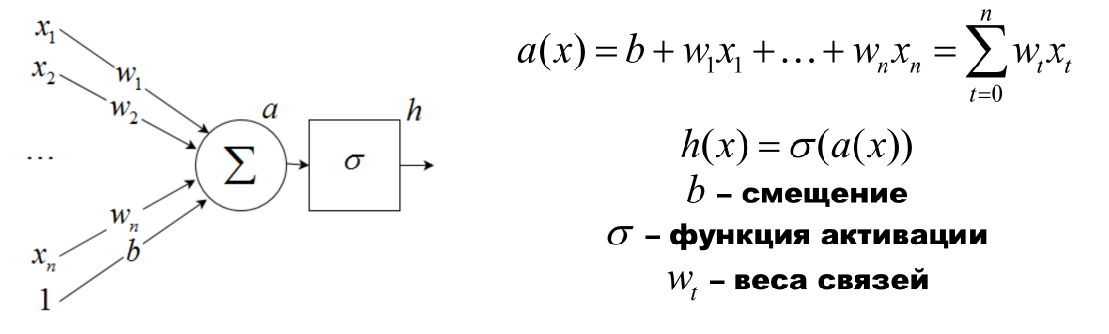

Итак, нейрон считает линейную комбинацию входов. Этого маловато для того, чтобы уметь хорошо аппроксимировать какие-то интересные функции, которые задают взаимосвязи в нашей конкретной задаче. Поэтому на выходе нейрона практически всегда используется нелинейная **функция активации**.

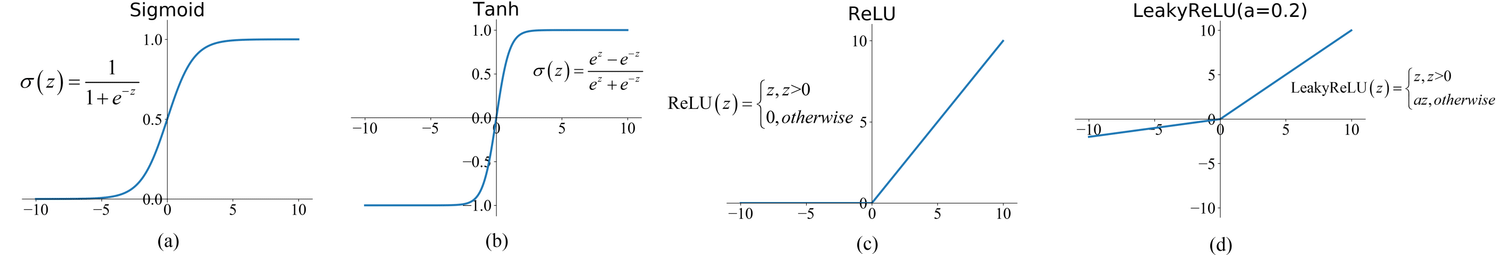

Естественно, при написании кода мы уже не очень задумываемся о модели нейрона - мы просто используем скалярное (а для группы нейронов сразу матричное) умножение.

По сути нейронные сети любого типа просто реализуют различные формы матричного умножения, так что можно смело заменять в любых фразах "Искусственный интеллект" на "Матричное умножение", и фразы типа "Искусственный интеллект скоро поработит мир" будут звучать веселее.

### **Multi-Layer Perceptron (MLP)**

Но один нейрон это слишком слабая модель, это даже не сеть. Будем использовать нейроны друг за другом и объединять в слои так, чтобы нейроны одного слоя работали параллельно и каждый передавал результат своей работы дальше - всем нейронам из следующего слоя. Слои эти называют `dense`/`linear`/`fully-connected layer`/полносвязный слой.

Сеть, которая состоит из полносвязных слоев называется Многослойным перцептроном (`Multi-Layer Perceptron - MLP`), или (`Feed Forward Network - FFN`), или просто Полносвязной сетью (`Fully-Connected Network` - `FCN`). В сети нет циклов, каждый нейрон каждого слоя такой сети связан со всеми нейронами с предыдущего слоя, а количество нейронов на выходе равно числу классов в задаче классификации, которую мы хотим решить с помощью этой сети. Таким образом каждый выходной нейрон активируется только на свой класс.

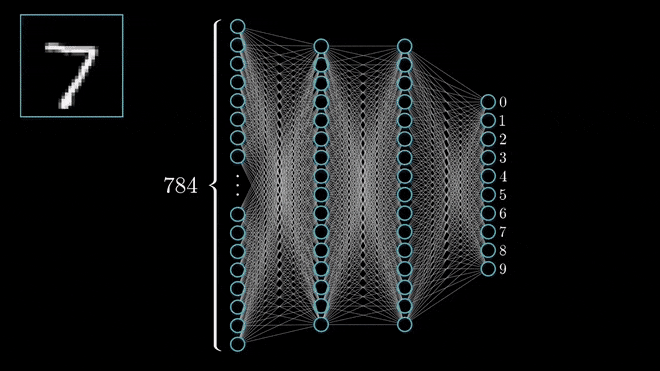

Линейный слой осуществляет линейное преобразование $y=xW^T+b$.

Каждый слой многослойной нейросети - это матрица весов, одна размерность которой - это нейроны, а другая - веса каждого нейрона для `i`-го входа.

$W, b$ - это обучаемые параметры линейного слоя. Именно их для каждого слоя надо настроить таким образом, чтобы сеть работала и отличала Наруто от Саске.






### **Пишем MLP/FCN**

Создадим полносвязную сетку так, чтобы в ней было несколько [линейных слоев](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) а между ними активации [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU).

**!** При написании `FCN` важно не забывать, что число выходов одного слоя должно совпадать с числом входов следующего.

In [ ]:
# Оборачиваем слои в nn.Sequential - https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

EasyNet = nn.Sequential(
    nn.Linear(127, 1984),
    nn.ReLU(),
    nn.Linear(1984, 165),
    nn.ReLU(),
    nn.Linear(165, 2)
)

print(EasyNet)

In [ ]:
EasyNet[0].state_dict()['bias'].shape

In [ ]:
# Заведём класс нашей собственной сетки, унаследовав основные свойства от nn.Module
class CoolEasyNet(nn.Module):
    def __init__(self, input_size, n_classes):
        super(CoolEasyNet, self).__init__()

        # тут в качестве атрибутов класса мы прописываем слои
        self.input_size = input_size
        self.n_classes = n_classes

        self.lin1 = nn.Linear(self.input_size, 2048)
        self.lin2 = nn.Linear(2048, 1024)
        self.lin3 = nn.Linear(1024, self.n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.lin3(x)

        return x

model = CoolEasyNet(input_size=4096, n_classes=13)

In [ ]:
model.lin1.state_dict()

## **3. Как обучить нейронную сеть**

Что из себя представляет сеть мы разобрались. А как её чему-нибудь обучить? Что вообще для сети значит быть обученной?

Мы хотим настроить параметры всех линейных слоев нашей сети - $W_1, W_2, W_3,..., W_n$ так, чтобы в последнем слое сети активировался правильный нейрон (в нем было бы самое большое значение) при проходе через сеть картинки этого класса. Это довольно сложная оптимизационная задача.



### Как формализовать такой запрос?

Введем понятие **функция потерь** `L (loss)` - аргументами её будут выходы сети и метки классов. И если на конкретной картинке предсказание сети будет отличаться от класса этой картинки, мы будем *нести потери*, то есть `loss` будет большой, если же предсказание верное, то `loss` будет нулевой.

Пусть $(X, y)$ - картинка и её метка, а $(p_0, p_1,...,p_n)$ - значения нейронов на последнем слое, тогда $L_X = L(y, [p_0, p_1, ..., p_n])$, но на самом деле $L = L(w)$.

Если мы посчитаем $L$ на всех объектах обучающей выборки, сложим и усредним, то получим средние потери, которые при текущих весах создает наш алгоритм, а мы хотим чтобы эти потери становились всё меньше и меньше по мере обучения сети (настройки параметров $W_i$). Таким образом наша глобальная задача - минимизировать средний `Loss`.

$$L(w)={\frac {1}{N}}\sum _{i=1}^{N}L_{i}(w) \rightarrow \min $$

То есть сделать что-то такое:

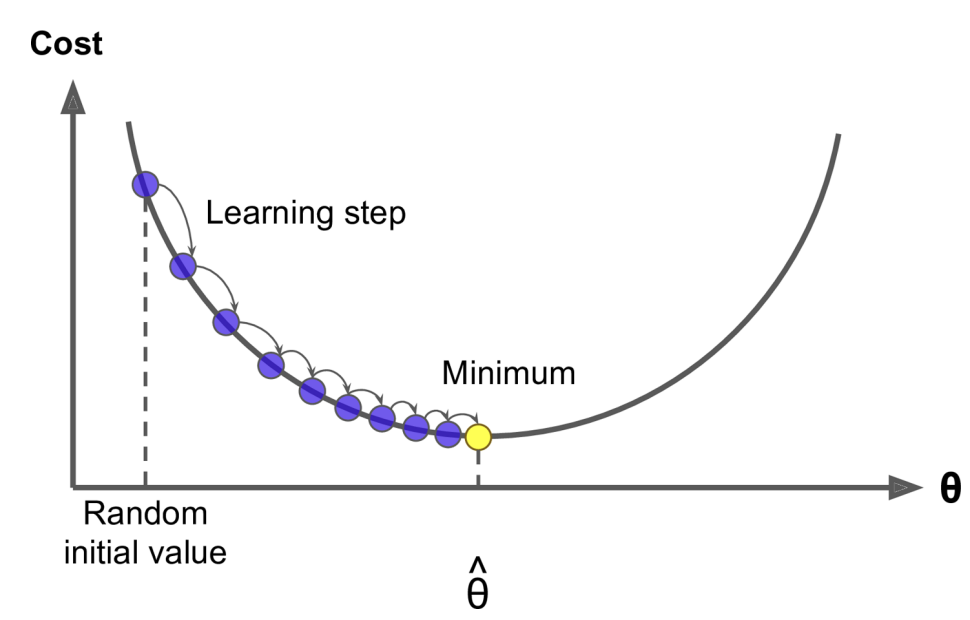

Делают это в самом просто случае с помощью [Метода Стохастического градиентного спуска](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA).

**Градиент** - это вектор, который для функции многих переменных указывает направление наискорейшего роста этой функции, тогда минус градиент (антиградиент) будет указывать направлением наискорейшего уменьшения значения функции, а это путь к её минимуму, нам туда и надо.

Описывается он следующей формулой:

$$w^{(t)}= w^{(t-1)}-\eta \nabla L_{i}(w)$$

  А алгоритм такой:

    1. Выбираем начальный w и скорость обучения eta.

    2. Повторяем пока не получим приблизительный минимум:

        Случайным образом перемешиваем примеры в тренировочном множестве.
        
        Для i=1,2,...,N выполняем:
        
          w_t = w_(t-1) - eta * grad(L(w))

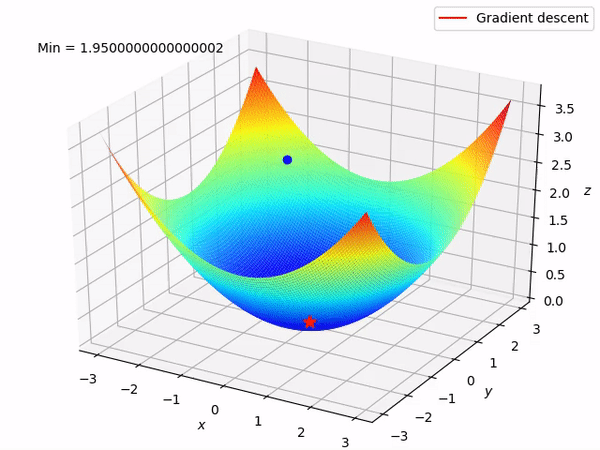

Но как же нам считать градиент такой сложной функции?

Тут в дело вступает [метод обратного распространения ошибки](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8) или [`backpropagation`](https://en.wikipedia.org/wiki/Backpropagation). Идея его состоит в том, чтобы вычислять значения градиентов от последнего слоя до первого по цепному правилу. Это возможно потому, что по сути сеть - это сложная функция, которая на каждом слудующем слое преобразует выход предыдущего слоя и представить её можно как $f(X) = f_k(f_{k-1}(f_{k-2}(....(f_1(X)))))$

Ещё одно очень интересное видео про градиентный спуск и `backprop` посмотрите [тут](https://www.youtube.com/watch?v=IHZwWFHWa-w).

На самом деле обновлять градиенты мы будем не по каждому отдельному элементу, а по небольшой группе элементов - **батчу**. Говорят, что если сеть увидела все картинки обучающей выборки и обновила свои веса в соответствии с каждой из них, то прошла одна **эпоха** для этой сети.

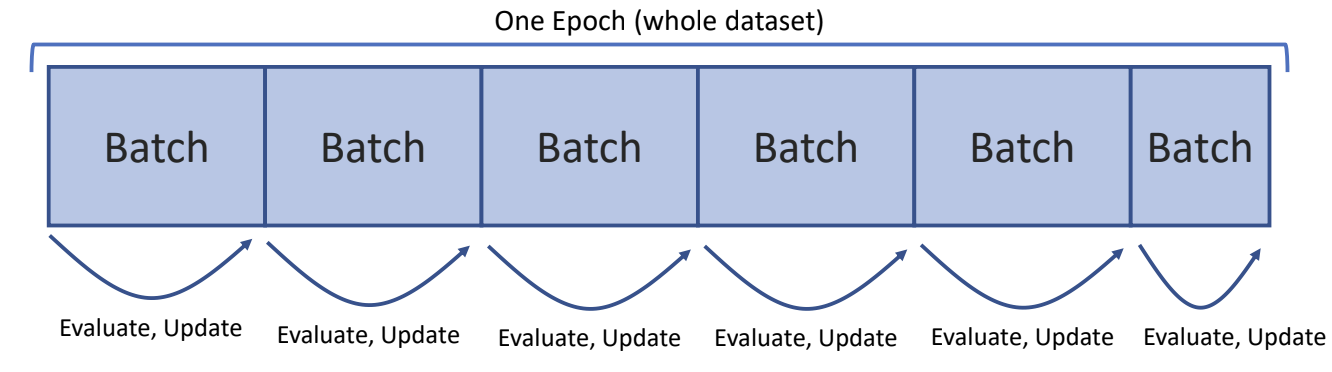

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Основная функция для обучения сети
def train_net(n_epochs, net, optimizer, criterion, trainloader, testloader, verbose=True):

    net = net.train() # Переводим сеть в режим обучения

    # Заводим списки для хранения метрик по эпохам
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    # Вот и главная петля - учим сеть в течение необходимого числа эпох
    for epoch in range(n_epochs):
        running_loss = 0.
        correct = 0.
        total = 0.

        # Итерируемся по всем батчам что есть в trainloader
        for data in tqdm(trainloader):
            inputs, labels, _ = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad() # Зануляем градиенты в листовых вершинах нашего вычислительного графа
            outputs = net(inputs) # Прогоняем входы через сеть и получаем её ответ
            _, predicted = torch.max(outputs.data, dim=1) # Для каждой картинки считаем

            # Статистики для подсчета Accuracy
            total += labels.size(0)
            correct += float((predicted == labels).sum())

            loss = criterion(outputs, labels) # считаем loss по верным меткам и выходам сети
            loss.backward() # Делаем шаг по антиградиенту
            optimizer.step() # Обновляем веса сети
            running_loss += float(loss) # Вычисляем скользящий лосс

        # Логируем после каждой эпохи
        if verbose:
            test_loss_iter, test_accuracy = evaluate_net(net, testloader)
            print('Epoch {}. Train_loss: {:.3f}' .format(epoch + 1, running_loss / len(trainloader)))
            print('Test_accuracy: {:.3f}, test_loss: {:.3f}' .format(test_accuracy, test_loss_iter))
            print('------------------------------')

        # Пополняем списки статистик
        train_loss.append(running_loss / len(trainloader))
        test_loss.append(test_loss)
        train_acc.append(correct/total)
        test_acc.append(test_accuracy)

    if verbose:
        print('Finished Training')

    return train_loss, test_loss, train_acc, test_acc

In [ ]:
# функция тестирования
def evaluate_net(net, testloader):
    net = net.eval() # Переводим сеть в режим теста

    loss = 0.
    correct = 0.
    total = 0.

    with torch.no_grad():
        for data in testloader:
            images, labels, _ = data # Получаем очередной батч: картинки + метки классов
            images = images.cuda() # Перекладываем картинки на видеокарту

            outputs = net(images).cpu() # Получаем выходы сети
            _, predicted = torch.max(outputs.data, dim=1) # Берём индекс максимального выхода

            total += labels.size(0) # Суммируем общее количество примеров в тесте по батчам
            correct += float((predicted == labels).sum()) # Суммируем количество правильных предсказаний
            loss += float(criterion(outputs, labels)) # Суммируем значения всех лоссов

    mean_loss = loss / len(testloader) # Средний лосс на тесте
    accuracy = correct / total # Точность на тесте

    return mean_loss, accuracy

## **4. Проводим эксперимент**

Итак, мы зашли уже достаточно далеко, пора собрать всё вместе и учить сеть.

In [ ]:
model = CoolEasyNet(input_size=np.prod((3, 64, 64)), n_classes=13)
model = model.cuda()

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
%%time
train_loss, test_loss, train_acc, test_acc = train_net(epochs, model, optimizer,
                                                       criterion, trainloader, testloader)

In [ ]:
def get_preds(net, testloader):
    net = net.eval() # переводим сеть в режим теста

    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels, impaths = data # Получаем очередной батч: картинки + метки классов
            images = images.cuda() # Перекладываем картинки на видеокарту

            outputs = net(images).cpu() # Получаем выходы сети
            outputs = F.softmax(outputs.data, dim=1) # Превращаем их в вероятности
            probs, preds = torch.max(outputs, dim=1) # Берём индекс максимального выхода

            probs = probs.data.tolist()
            preds = preds.data.cpu().numpy()
            labels = labels.data.cpu().numpy()

            df = pd.DataFrame(zip(impaths, labels, preds, probs), columns=['image_name', 'class', 'pred', 'score']) # Укладываем в датафрейм

            if i: # если i уже не 0
                results = pd.concat([results, df])
            else: # если i ещё 0
                results = df

    return results

In [ ]:
results = get_preds(model, testloader)

In [ ]:
cm = confusion_matrix(results['class'], results['pred'])
cm_norm = confusion_matrix(results['class'], results['pred'], normalize='true')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm, annot=True, ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, ax=ax[1], fmt='0.1f')
ax[1].set_title('Normalized Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.show()

In [ ]:
def vis_mistakes(class_true, results):
    mistakes_to_vis = results[(results['class'] == class_true) & (results['pred'] != class_true)]
    mistakes_to_vis.sort_values(by=['score'], inplace=True, ascending=False)
    mistakes_to_vis.reset_index(inplace=True, drop=True)
    print(f'Number of mistakes: {len(mistakes_to_vis)}')
    count = min(len(mistakes_to_vis), 4)
    fig, ax = plt.subplots(1, count, figsize=(count*5, 10))

    for i, row in mistakes_to_vis.head(4).iterrows():
        img = cv2.imread(os.path.join(root, row['image_name']))
        ax[i].imshow(img[:, :, ::-1])
        ax[i].title.set_text(f"GT: {class_map[row['class']]}, Pred: {class_map[row['pred']]}, Score: {row['score']:,.2f}")
        ax[i].axis('off')

In [ ]:
vis_mistakes(class_true=0, results=results)

## **5. Take-home Things**





Обязательно поэкспериментируйте ещё:
- а что, если добавить больше слоёв,
- а поиграть с количеством нейронов в слоях,
- может использовать разрешение картинок побольше,
- может учить подольше,
- может`lr` можно подобрать оптимальнее,
- или использовать [`Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) оптимизатор,
- а может стоит поиграть с [аугментацией](https://pytorch.org/vision/stable/transforms.html) при подготовке данных - вариативность огромна даже просто для полносвязных сетей.

Попробуйте добиться лучшего качества для этого датасета.

**P.S.** Вообще говоря, мы уже давно не используем в настоящих CV задачах чисто полносвязные сети, решение real-world задач с 2012 года уже не представляют без [свёрток](https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/), но это уже совсем другая история :)

Если вам стало интересно, вот ещё несколько классных материалов по CV:
0. [Официальные туториалы от PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html)
1. Плейлист [PyTorch Tutorials](https://www.youtube.com/playlist?list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz)
2. [Цикл из двух статей с обзором задач в CV](https://habr.com/ru/companies/mipt/articles/450732/)
3. [Мой пост на Хабре про транспортную видеоаналитику](https://habr.com/ru/companies/ru_mts/articles/838098/)
4. [Как распоспознают асаны с помощью CV](https://habr.com/ru/articles/555162/)
5. [Как в Яндексе сделали OCR для распознавания любого текста](https://habr.com/ru/companies/yandex/articles/475956/)
6. [Демо Segment Anything Model](https://segment-anything.com/demo), в котором вы сможете сегментировать что угодно.

**GL, HF**